In [1]:
from google.colab import files
uploaded= files.upload()

Saving Argentina_drought.csv to Argentina_drought.csv


In [2]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import base64
from io import BytesIO
import requests
import re
import io
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
argentina_drought= pd.read_csv('Argentina_drought.csv')

In [4]:
argentina_drought.head(10)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,category,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1.401261e+18,1.401261e+18,2021-06-05 15:31:58 EDT,2021-06-05,03:31:58 PM,-400,1.069709e+18,bitter_b0xx,b @ exams & HW,NaN,squeee its about to rain im super happy!!!1! I...,none,en,[],[],[],1,0,1,[],[],https://twitter.com/bitter_b0xx/status/1401260...,False,NaN,0,NaN,Argentina,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1.400889e+18,1.400600e+18,2021-06-04 14:54:34 EDT,2021-06-04,02:54:34 PM,-400,1.341297e+08,edreynolds17,eduardo reynolds,NaN,@Engineer_Farmer just have a look a the desert...,none,en,[],[],[],1,0,1,[],[],https://twitter.com/edreynolds17/status/140088...,False,NaN,0,NaN,Argentina,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Engineer_Farmer', 'name': 'A...",NaN,NaN,NaN,NaN
2,1.400248e+18,1.400248e+18,2021-06-02 20:28:36 EDT,2021-06-02,08:28:36 PM,-400,1.393095e+18,mpiedrav,Marco Piedra Venegas,NaN,Climate change is of no concern for future eli...,none,en,[],[],[],1,0,0,[],[],https://twitter.com/mpiedrav/status/1400248015...,False,NaN,0,NaN,Argentina,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1.399385e+18,1.399385e+18,2021-05-31 11:18:41 EDT,2021-05-31,11:18:41 AM,-400,1.443053e+08,vivisjoon,iari&⁷ 🥞,NaN,5 months of drought...FIVE MONTHS,none,en,[],[],[],0,0,0,[],[],https://twitter.com/vivisjoon/status/139938484...,False,NaN,0,NaN,Argentina,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [5]:
argentina_drought.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'category', 'language',
       'mentions', 'urls', 'photos', 'replies_count', 'retweets_count',
       'likes_count', 'hashtags', 'cashtags', 'link', 'retweet', 'quote_url',
       'video', 'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [7]:
#Removing unwanted columns
argentina_drought= argentina_drought.drop(['conversation_id', 'created_at','timezone','user_id', 'username', 'name','place','mentions', 
                                           'urls','replies_count', 'retweets_count','likes_count','cashtags', 'retweet', 'quote_url',
                                           'video', 'thumbnail','geo','user_rt_id', 'user_rt','retweet_id', 'reply_to', 'retweet_date', 
                                           'translate', 'trans_src','trans_dest','source'],axis=1)

In [9]:
argentina_drought.columns

Index(['id', 'date', 'time', 'tweet', 'category', 'language', 'photos',
       'hashtags', 'link', 'near'],
      dtype='object')

In [10]:
#rename the column names
argentina_drought.rename(columns={'id':'Id','link':'source URL','near':'country','hashtags':'keywords'},inplace=True)

In [12]:
#merge tweet and photos column and drop tweet and photos link seperate column
argentina_drought['body']= argentina_drought['tweet']+argentina_drought['photos']
argentina_drought= argentina_drought.drop(['tweet','photos'],axis=1)

In [14]:
#merge data and time column 
argentina_drought['time']= argentina_drought['date']+' '+argentina_drought['time']
argentina_drought= argentina_drought.drop(['date'],axis=1)

In [15]:
#added data source column
argentina_drought['data source']= 'Twitter'

In [16]:
argentina_drought['time']= pd.to_datetime(argentina_drought['time'], errors='coerce',utc=True)
argentina_drought['Id']= argentina_drought['Id'].astype(object)

In [17]:
argentina_drought.head(5)

,Id,time,category,language,keywords,source URL,country,body,data source
0,1.40126e+18,2021-06-05 15:31:58+00:00,none,en,[],https://twitter.com/bitter_b0xx/status/1401260...,Argentina,squeee its about to rain im super happy!!!1! I...,Twitter
1,1.40089e+18,2021-06-04 14:54:34+00:00,none,en,[],https://twitter.com/edreynolds17/status/140088...,Argentina,@Engineer_Farmer just have a look a the desert...,Twitter
2,1.40025e+18,2021-06-02 20:28:36+00:00,none,en,[],https://twitter.com/mpiedrav/status/1400248015...,Argentina,Climate change is of no concern for future eli...,Twitter
3,1.39938e+18,2021-05-31 11:18:41+00:00,none,en,[],https://twitter.com/vivisjoon/status/139938484...,Argentina,5 months of drought...FIVE MONTHS[],Twitter


In [18]:
argentina_drought.shape

(4, 9)

In [19]:
argentina_drought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   Id           4 non-null      object             
 1   time         4 non-null      datetime64[ns, UTC]
 2   category     4 non-null      object             
 3   language     4 non-null      object             
 4   keywords     4 non-null      object             
 5   source URL   4 non-null      object             
 6   country      4 non-null      object             
 7   body         4 non-null      object             
 8   data source  4 non-null      object             
dtypes: datetime64[ns, UTC](1), object(8)
memory usage: 416.0+ bytes


In [22]:
argentina_drought['title']=''

In [23]:
argentina_drought= argentina_drought[['Id','title','time','keywords','data source','category','country','source URL','body','language']]

In [24]:
argentina_drought.head(7)

,Id,title,time,keywords,data source,category,country,source URL,body,language
0,1.40126e+18,,2021-06-05 15:31:58+00:00,[],Twitter,none,Argentina,https://twitter.com/bitter_b0xx/status/1401260...,squeee its about to rain im super happy!!!1! I...,en
1,1.40089e+18,,2021-06-04 14:54:34+00:00,[],Twitter,none,Argentina,https://twitter.com/edreynolds17/status/140088...,@Engineer_Farmer just have a look a the desert...,en
2,1.40025e+18,,2021-06-02 20:28:36+00:00,[],Twitter,none,Argentina,https://twitter.com/mpiedrav/status/1400248015...,Climate change is of no concern for future eli...,en
3,1.39938e+18,,2021-05-31 11:18:41+00:00,[],Twitter,none,Argentina,https://twitter.com/vivisjoon/status/139938484...,5 months of drought...FIVE MONTHS[],en


**preprocess body(tweets)= removed 'https' links and username defined by @, as links are not useful**


In [25]:
def cleaned_data(text):
    clean=re.sub("http\S+","",text)
    clean = clean.lower()
    clean=re.sub("@\S+","",clean)
    clean = re.sub('#', ' ', clean)
    clean = re.sub('&amp', ' ', clean)
    # clean = re.sub(':', ' ', clean)
    clean = re.sub('/', ' ', clean)
    clean = re.sub(r'\?{2,}', '?', clean)
    clean = re.sub(r'\!{2,}', '!', clean)
    clean = re.sub(r'\.{2,}', '.', clean)
    clean = re.sub('\[', '', clean)
    clean = re.sub('\]', '', clean)
    clean = re.sub(';', '', clean)
    clean = re.sub(r'[(]', ' ', clean)
    clean = re.sub(r'[)]', ' ', clean)
    clean = re.sub(r'@', ' ', clean)
    # clean = re.sub(r'/*', ' ', clean)
    clean = re.sub('-', ' ', clean)
    # clean = re.sub(r'([a-z])\1+', r'\1', clean)  # this is for bring character to once if it is repeating more than once
    # clean = re.sub('flod', 'flood', clean)
    # clean = re.sub('floding', 'flooding', clean)
    clean=re.sub('"'," ",clean)
    clean=re.sub("\s{2,}"," ",clean)
    clean=clean.strip()
    # clean = TextBlob(clean).correct()
    return clean

In [26]:
argentina_drought['cleaned body'] = argentina_drought['body'].apply(cleaned_data)

In [27]:
!pip install contractions

     |████████████████████████████████| 327kB 2.9MB/s 
     |████████████████████████████████| 286kB 23.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85402 sha256=f7b478cb5a3acbbd815db18f68bfc92afbbdf6fadad27655e6177a95fac3b4d0
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [28]:
import contractions

In [29]:
def expanded(text):
    expanded_words = []    
    try:
      for word in text.split():
        expanded_words.append(contractions.fix(word))
    except Exception:
      pass         
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [30]:
argentina_drought['cleaned body'] = argentina_drought['cleaned body'].apply(expanded)

In [31]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def final_pre_pro(text):
  clean = re.sub('\+','',text)
  clean = re.sub('=','',text)
  clean = re.sub('\_{2,}',' ',text)
  clean = re.sub('\*',' ',text)
  clean=re.sub("\s{2,}"," ",clean)
  return clean.strip()

In [32]:
argentina_drought['cleaned body'] = argentina_drought['cleaned body'].apply(remove_emojis)
argentina_drought['cleaned body'] = argentina_drought['cleaned body'].apply(final_pre_pro)

In [33]:
argentina_drought.head(5)

,Id,title,time,keywords,data source,category,country,source URL,body,language,cleaned body
0,1.40126e+18,,2021-06-05 15:31:58+00:00,[],Twitter,none,Argentina,https://twitter.com/bitter_b0xx/status/1401260...,squeee its about to rain im super happy!!!1! I...,en,squeee its about to rain I am super happy!1! I...
1,1.40089e+18,,2021-06-04 14:54:34+00:00,[],Twitter,none,Argentina,https://twitter.com/edreynolds17/status/140088...,@Engineer_Farmer just have a look a the desert...,en,"just have a look a the deserts, that is drough..."
2,1.40025e+18,,2021-06-02 20:28:36+00:00,[],Twitter,none,Argentina,https://twitter.com/mpiedrav/status/1400248015...,Climate change is of no concern for future eli...,en,climate change is of no concern for future eli...
3,1.39938e+18,,2021-05-31 11:18:41+00:00,[],Twitter,none,Argentina,https://twitter.com/vivisjoon/status/139938484...,5 months of drought...FIVE MONTHS[],en,5 months of drought.five months


In [34]:
#rearange all columns as per final datsets column
argentina_drought= argentina_drought[['Id','title','time','keywords','data source','category','country','source URL','body','cleaned body','language']]

In [35]:
argentina_drought.head(5)

,Id,title,time,keywords,data source,category,country,source URL,body,cleaned body,language
0,1.40126e+18,,2021-06-05 15:31:58+00:00,[],Twitter,none,Argentina,https://twitter.com/bitter_b0xx/status/1401260...,squeee its about to rain im super happy!!!1! I...,squeee its about to rain I am super happy!1! I...,en
1,1.40089e+18,,2021-06-04 14:54:34+00:00,[],Twitter,none,Argentina,https://twitter.com/edreynolds17/status/140088...,@Engineer_Farmer just have a look a the desert...,"just have a look a the deserts, that is drough...",en
2,1.40025e+18,,2021-06-02 20:28:36+00:00,[],Twitter,none,Argentina,https://twitter.com/mpiedrav/status/1400248015...,Climate change is of no concern for future eli...,climate change is of no concern for future eli...,en
3,1.39938e+18,,2021-05-31 11:18:41+00:00,[],Twitter,none,Argentina,https://twitter.com/vivisjoon/status/139938484...,5 months of drought...FIVE MONTHS[],5 months of drought.five months,en


In [36]:
argentina_drought['category'].value_counts()

none    4
Name: category, dtype: int64

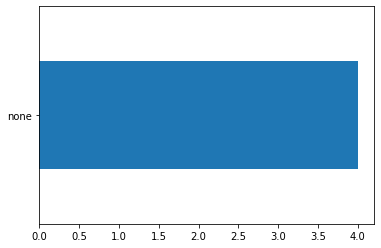

In [37]:
argentina_drought['category'].value_counts().plot(kind='barh')

In [39]:
argentina_drought.to_csv('argentina_drought_tweets_transformed.csv', index=False)